In [21]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_markdown

import os
from pathlib import Path
from typing import Dict

%cd ..
from models import RNN, CNN, ConvolutionalRNN, ConvolutionalTransformer, VisionTransformer
%cd notebooks

plt.style.use('ggplot')
study_path = Path(os.getcwd()).parent.resolve() / "study"

/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [22]:
# Declare every model and dataset
models = [RNN, CNN, ConvolutionalRNN, ConvolutionalTransformer, VisionTransformer]
datasets = ["ENST+MDB", "EGMD", "SLAKH", "ADTOF-YT"]
expanded_datasets = datasets + ["SADTP"]

In [23]:
# Declare helper functions
def extract_architecture_performances(study: Path, model: str) -> Dict[str, float]:
    path = study / model
    if not path.exists():
        return {}

    performances = {}
    for dataset in path.iterdir():
        if dataset.is_dir() and not dataset.name.startswith("."):
            with open(dataset / "results.txt") as f:
                performances[dataset.name] = round(float(f.readlines()[6].split(" ")[-1].strip()), 2)
    
    return performances

def extract_dataset_performances(study: Path, model: str) -> Dict[str, float]:
    path = study / model
    if not path.exists():
        return {}

    performances = {}
    for train_dataset in path.iterdir():
        if train_dataset.is_dir() and not train_dataset.name.startswith("."):
            performances[train_dataset.name] = {}
            with open(train_dataset / "tests.txt") as f:
                lines = f.readlines()
                for i in range(len(lines) // 4):
                    test_dataset = lines[i * 4].split(" ")[4].replace("_", "-")
                    performance = round(float(lines[i * 4 + 1].split(" ")[-1].strip()), 2)
                    performances[train_dataset.name][test_dataset] = performance
    
    return performances

# Analysis of the Architecture study

### Analyse the different models" performance on different datasets

In [24]:
# Compute the different performances
architecture_path = study_path / "Architecture"

architecture_performances = {model: extract_architecture_performances(architecture_path, model.name) for model in models}

In [25]:
# Find and print their respective performances
markdown = "## Architecture study performances\n"
markdown += f"| Model | {'|'.join(datasets)} |\n"
markdown += f"|:--|{'--:|'.join('' for _ in datasets)}--:|\n"

for model in models:
    markdown += f"|{model.name}|"
    for dataset in datasets:
        if model in architecture_performances and dataset in architecture_performances[model]:
            performance = architecture_performances[model][dataset]
            if performance == max(architecture_performances[m][dataset] for m in models):
                markdown += f"**{performance}**|"
            else:
                markdown += f"{performance}|"
        else:
            markdown += "|"
    markdown += "\n"

display_markdown(markdown, raw=True)

## Architecture study performances
| Model | ENST+MDB|EGMD|SLAKH|ADTOF-YT |
|:--|--:|--:|--:|--:|
|RNN|0.67|**0.9**|0.86|**0.96**|
|CNN|0.78|0.88|0.83|0.84|
|Convolutional RNN|**0.81**|**0.9**|**0.9**|0.93|
|Convolutional Transformer|0.78|0.89|0.88|0.95|
|Vision Transformer|0.54|0.89|0.88|**0.96**|


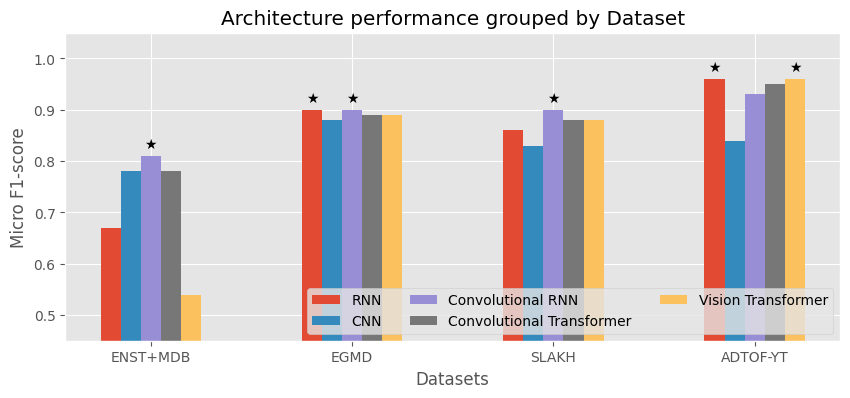

In [26]:
# Plot performances
x = np.arange(len(datasets))
width = 0.1
multiplier = -1

fig, ax = plt.subplots(figsize=(10, 4))
for model in models:
    performances = [architecture_performances[model][dataset] for dataset in datasets]
    offset = width * multiplier
    rects = ax.bar(x + offset, performances, width, label=model.name)
    
    bar_labels = ["★" if architecture_performances[model][dataset] == max(architecture_performances[m][dataset] for m in models) else "" for dataset in datasets]
    ax.bar_label(rects, bar_labels, padding=3)
    multiplier += 1
    
ax.set_ylabel("Micro F1-score")
ax.set_xlabel("Datasets")
ax.set_title("Architecture performance grouped by Dataset")
ax.set_xticks(x + width, datasets)
ax.set_ylim(0.45, 1.05)
ax.legend(bbox_to_anchor=(1.0, 0.0), loc="lower right", ncols=3)
plt.savefig("../thesis/figures/architectureperformancedataset.png", bbox_inches='tight')
plt.show()

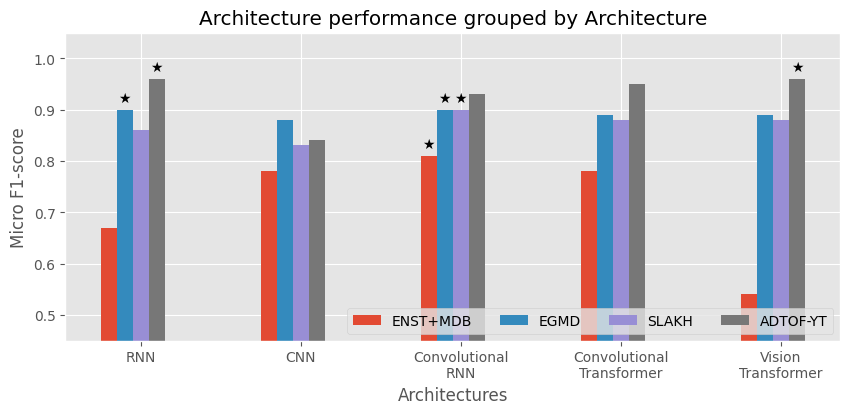

In [27]:
# Plot performances
x = np.arange(len(models))
width = 0.1
multiplier = -1

fig, ax = plt.subplots(figsize=(10, 4))
for dataset in datasets:
    performances = [architecture_performances[model][dataset] for model in models]
    offset = width * multiplier
    rects = ax.bar(x + offset, performances, width, label=dataset)

    bar_labels = ["★" if performance == max(performances) else "" for performance in performances]
    ax.bar_label(rects, bar_labels, padding=3)
    multiplier += 1
    
ax.set_ylabel("Micro F1-score")
ax.set_xlabel("Architectures")
ax.set_title("Architecture performance grouped by Architecture")
ax.set_xticks(x + width, [model.name.replace(" ", "\n") for model in models])
ax.set_ylim(0.45, 1.05)
ax.legend(bbox_to_anchor=(1.0, 0.0), loc="lower right", ncols=4)
plt.savefig("../thesis/figures/architectureperformancearchitecture.png", bbox_inches='tight')
plt.show()

# Analysis of the Dataset study

### Analyse a model"s performance on different datasets, based on a separate training dataset

In [28]:
# Compute the different performances
dataset_path = study_path / "Dataset"

dataset_performances = (extract_dataset_performances(architecture_path, "Convolutional RNN")
                       | extract_dataset_performances(dataset_path, "Convolutional RNN"))

In [29]:
# Find and print their respective performances
markdown = "## Dataset study performances\n"
markdown += f"| Model | {'|'.join(expanded_datasets)} |\n"
markdown += f"|:--|{'--:|'.join('' for _ in expanded_datasets)}--:|\n"

for training_dataset, performances in dataset_performances.items():
    markdown += f"|{training_dataset}|"
    for dataset in expanded_datasets:
        if training_dataset in dataset_performances and dataset in dataset_performances[training_dataset]:
            performance = dataset_performances[training_dataset][dataset]
            if dataset in training_dataset:
                if performance == max(dataset_performances[t][dataset] for t in dataset_performances.keys() if dataset in t):
                    markdown += f"***{performance}***|"
                else:
                    markdown += f"*{performance}*|"
            else:
                if performance == max(dataset_performances[t][dataset] for t in dataset_performances.keys() if dataset not in t):
                    markdown += f"**{performance}**|"
                else:
                    markdown += f"{performance}|"
        else:
            markdown += "|"
    markdown += "\n"

display_markdown(markdown, raw=True)

## Dataset study performances
| Model | ENST+MDB|EGMD|SLAKH|ADTOF-YT|SADTP |
|:--|--:|--:|--:|--:|--:|
|EGMD|0.55|***0.9***|0.44|0.42|0.28|
|SLAKH|0.8|0.73|***0.9***|0.59|0.48|
|ENST+MDB|*0.81*|0.59|0.53|0.6|0.42|
|ADTOF-YT|0.84|0.69|**0.65**|*0.93*|0.61|
|EGMD+SLAKH+ADTOF-YT|0.85|***0.9***|*0.89*|*0.93*|0.61|
|ENST+MDB+SLAKH+ADTOF-YT|***0.88***|**0.74**|*0.89*|*0.95*|0.61|
|SLAKH+ADTOF-YT|**0.86**|0.72|***0.9***|***0.96***|**0.62**|
|ENST+MDB+ADTOF-YT|*0.86*|0.7|0.63|*0.94*|**0.62**|
|ENST+MDB+EGMD+SLAKH+ADTOF-YT|*0.87*|*0.89*|***0.9***|*0.93*|**0.62**|
|ENST+MDB+SLAKH|*0.84*|0.73|***0.9***|**0.63**|0.47|


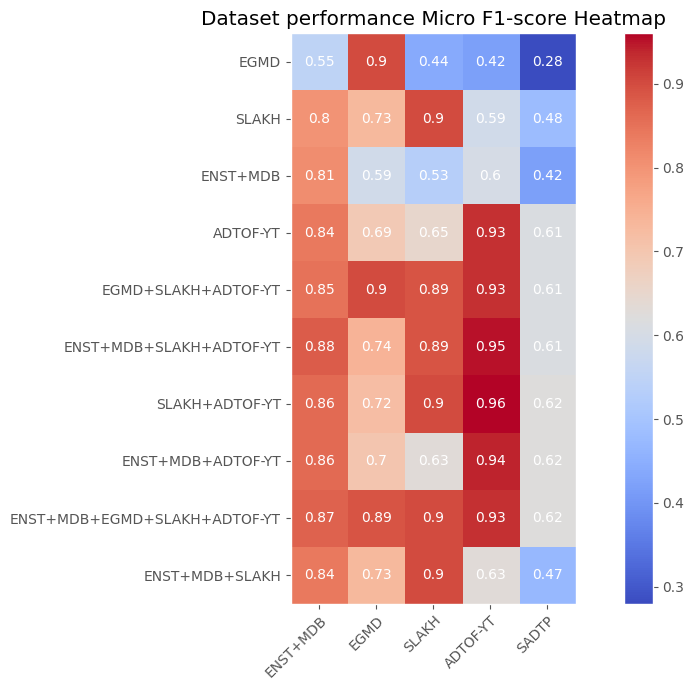

In [30]:
# Plot performances as a heatmap
fig, ax = plt.subplots(figsize=(10, 7))

heatmap = [list(performances.values()) for _, performances in dataset_performances.items()]
rows = [training_dataset for training_dataset in dataset_performances.keys()]
columns = list(list(dataset_performances.values())[0].keys())

image = ax.imshow(heatmap, cmap="coolwarm")
plt.colorbar(image)

ax.set_xticks(range(len(columns)), labels=columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(rows)), labels=rows)

# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(columns)):
        text = ax.text(j, i, heatmap[i][j],
                       ha="center", va="center", color="w")

ax.set_title("Dataset performance Micro F1-score Heatmap")
ax.grid(False)
plt.tight_layout()
plt.show()